In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [5]:
train_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\train'
test_path= r'C:\Users\DAWN\Documents\Python Scripts\python\data\test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=128, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [6]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [7]:
print(classes)

['benign', 'malignant']


In [62]:
class ConvNet(nn.Module):
    
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.LogSigmoid()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.LogSigmoid()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu3=nn.LogSigmoid()
        #Shape= (256,20,75,75)
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=48,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu4=nn.LogSigmoid()
        #Shape= (256,20,75,75)
        
        self.conv5=nn.Conv2d(in_channels=48,out_channels=64,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn5=nn.BatchNorm2d(num_features=64)
        #Shape= (256,32,75,75)
        self.relu5=nn.LogSigmoid()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 64,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.relu3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
            
        output=self.conv5(output)
        output=self.bn5(output)
        output=self.relu5(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,64*75*75)
        output=self.fc(output)            
        return output

In [63]:
model=ConvNet(num_classes=2).to(device)

In [66]:
optimizer=SGD(model.parameters(),lr=0.0005,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [67]:
num_epochs=100

In [68]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [69]:
print(train_count,test_count)

2637 660


In [70]:
ta = [0]*100
tl = [0]*100
tea = [0]*100
tel = [0]*100

In [71]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()

        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0) 
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_sigmoid_5lay.pth')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(34.0203) Train Accuracy: 0.4926052332195677 Test Accuracy: 0.5454545454545454
Epoch: 1 Train Loss: tensor(25.9979) Train Accuracy: 0.515737580583997 Test Accuracy: 0.5454545454545454
Epoch: 2 Train Loss: tensor(8.3659) Train Accuracy: 0.69548729616989 Test Accuracy: 0.6954545454545454
Epoch: 3 Train Loss: tensor(8.1600) Train Accuracy: 0.7004171406901782 Test Accuracy: 0.7272727272727273
Epoch: 4 Train Loss: tensor(7.2244) Train Accuracy: 0.720515737580584 Test Accuracy: 0.7378787878787879
Epoch: 5 Train Loss: tensor(7.7243) Train Accuracy: 0.6924535456958665 Test Accuracy: 0.7833333333333333
Epoch: 6 Train Loss: tensor(7.6853) Train Accuracy: 0.6992794842624194 Test Accuracy: 0.6045454545454545
Epoch: 7 Train Loss: tensor(6.0369) Train Accuracy: 0.7231702692453545 Test Accuracy: 0.65
Epoch: 8 Train Loss: tensor(7.6926) Train Accuracy: 0.7061054228289723 Test Accuracy: 0.7893939393939394
Epoch: 9 Train Loss: tensor(5.5687) Train Accuracy: 0.7318923018581721 

Epoch: 78 Train Loss: tensor(2.1275) Train Accuracy: 0.7679180887372014 Test Accuracy: 0.7696969696969697
Epoch: 79 Train Loss: tensor(3.1897) Train Accuracy: 0.7243079256731134 Test Accuracy: 0.646969696969697
Epoch: 80 Train Loss: tensor(1.8713) Train Accuracy: 0.7781569965870307 Test Accuracy: 0.7196969696969697
Epoch: 81 Train Loss: tensor(2.4312) Train Accuracy: 0.745544178991278 Test Accuracy: 0.7954545454545454
Epoch: 82 Train Loss: tensor(2.1905) Train Accuracy: 0.7679180887372014 Test Accuracy: 0.6424242424242425
Epoch: 83 Train Loss: tensor(3.0920) Train Accuracy: 0.7345468335229427 Test Accuracy: 0.7984848484848485
Epoch: 84 Train Loss: tensor(1.8402) Train Accuracy: 0.7766401213500189 Test Accuracy: 0.7393939393939394
Epoch: 85 Train Loss: tensor(2.5749) Train Accuracy: 0.7478194918467956 Test Accuracy: 0.7833333333333333
Epoch: 86 Train Loss: tensor(3.0419) Train Accuracy: 0.7406143344709898 Test Accuracy: 0.7909090909090909
Epoch: 87 Train Loss: tensor(1.6851) Train Accur

In [24]:
import torchinfo
torchinfo.summary(model, (3, 150, 150), batch_dim = 0, col_names = ('input_size', 'output_size', 'num_params', 
                                                                    'kernel_size', 'mult_adds'), verbose = 0)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
ConvNet                                  [1, 3, 150, 150]          [1, 2]                    --                        --                        --
├─Conv2d: 1-1                            [1, 3, 150, 150]          [1, 12, 150, 150]         336                       [3, 3]                    7,560,000
├─BatchNorm2d: 1-2                       [1, 12, 150, 150]         [1, 12, 150, 150]         24                        --                        24
├─LogSigmoid: 1-3                        [1, 12, 150, 150]         [1, 12, 150, 150]         --                        --                        --
├─MaxPool2d: 1-4                         [1, 12, 150, 150]         [1, 12, 75, 75]           --                        2                         --
├─Conv2d: 1-5                            [1, 12, 75, 75]           [1, 20, 75, 75]           2,180

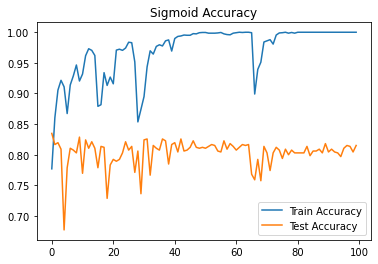

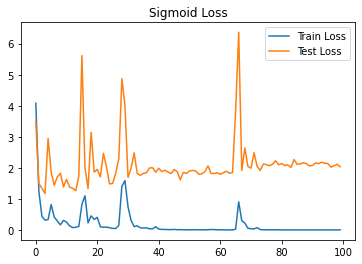

In [25]:
# 3x3, 32 channels, 3 layers
plt.title('Sigmoid Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Sigmoid Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

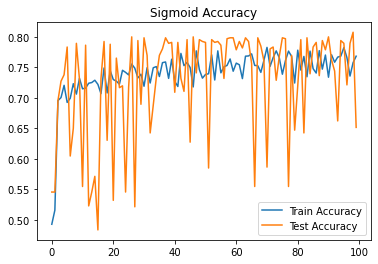

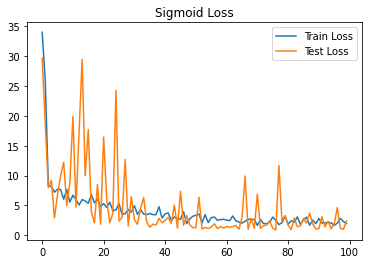

In [72]:
# 3x3, 64 channels, 5 layers
plt.title('Sigmoid Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Sigmoid Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [73]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]

In [74]:
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]

In [75]:
#Avg Difference in Accuracy
print(sa/100)

0.014118126659082303


In [76]:
#Avg Difference in Loss
sl/100

tensor(0.6734)

In [77]:
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [82]:
sl1/100

tensor(4.1133)

In [44]:
# using 5x5 kernel

In [45]:
class ConvNet(nn.Module):
    
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=5,stride=1,padding=2)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.LogSigmoid()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=5,stride=1,padding=2)
        #Shape= (256,20,75,75)
        self.relu2=nn.LogSigmoid()
        #Shape= (256,20,75,75)
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=5,stride=1,padding=2)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.LogSigmoid()
        #Shape= (256,32,75,75)
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
        output=self.fc(output)            
        return output

In [46]:
model=ConvNet(num_classes=2).to(device)

In [47]:
from torch.optim import NAdam
optimizer=NAdam(model.parameters(),lr=0.005,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [49]:
best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()

        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    # Evaluation on testing dataset
    model.eval()
    test_accuracy=0.0
    test_loss=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        test_loss+= loss.cpu().data*images.size(0) 
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    test_loss=test_loss/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    ta[epoch] = train_accuracy
    tl[epoch] = train_loss
    tea[epoch] = test_accuracy
    tel[epoch] = test_loss
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint_sigmoid_5x5.pth')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(98.7116) Train Accuracy: 0.6511186954872962 Test Accuracy: 0.7515151515151515
Epoch: 1 Train Loss: tensor(73.2426) Train Accuracy: 0.6806977626090254 Test Accuracy: 0.6545454545454545
Epoch: 2 Train Loss: tensor(40.5272) Train Accuracy: 0.7182404247250663 Test Accuracy: 0.6257575757575757
Epoch: 3 Train Loss: tensor(43.3044) Train Accuracy: 0.7121729237770194 Test Accuracy: 0.7833333333333333
Epoch: 4 Train Loss: tensor(45.9125) Train Accuracy: 0.7216533940083428 Test Accuracy: 0.7954545454545454
Epoch: 5 Train Loss: tensor(28.1306) Train Accuracy: 0.7572999620781191 Test Accuracy: 0.65
Epoch: 6 Train Loss: tensor(37.7610) Train Accuracy: 0.7224118316268487 Test Accuracy: 0.753030303030303
Epoch: 7 Train Loss: tensor(35.1730) Train Accuracy: 0.7345468335229427 Test Accuracy: 0.6151515151515151
Epoch: 8 Train Loss: tensor(39.2745) Train Accuracy: 0.7436480849450132 Test Accuracy: 0.753030303030303
Epoch: 9 Train Loss: tensor(23.9512) Train Accuracy: 0.7720894

Epoch: 78 Train Loss: tensor(3.7694) Train Accuracy: 0.7872582480091013 Test Accuracy: 0.7954545454545454
Epoch: 79 Train Loss: tensor(2.9791) Train Accuracy: 0.7906712172923777 Test Accuracy: 0.7242424242424242
Epoch: 80 Train Loss: tensor(2.8525) Train Accuracy: 0.7956010618126659 Test Accuracy: 0.6090909090909091
Epoch: 81 Train Loss: tensor(4.3012) Train Accuracy: 0.7819491846795601 Test Accuracy: 0.8409090909090909
Epoch: 82 Train Loss: tensor(3.8206) Train Accuracy: 0.7766401213500189 Test Accuracy: 0.7166666666666667
Epoch: 83 Train Loss: tensor(3.4804) Train Accuracy: 0.7948426241941601 Test Accuracy: 0.7924242424242425
Epoch: 84 Train Loss: tensor(4.7856) Train Accuracy: 0.764505119453925 Test Accuracy: 0.803030303030303
Epoch: 85 Train Loss: tensor(3.0674) Train Accuracy: 0.7974971558589306 Test Accuracy: 0.7484848484848485
Epoch: 86 Train Loss: tensor(2.9878) Train Accuracy: 0.7853621539628366 Test Accuracy: 0.7181818181818181
Epoch: 87 Train Loss: tensor(3.3503) Train Accur

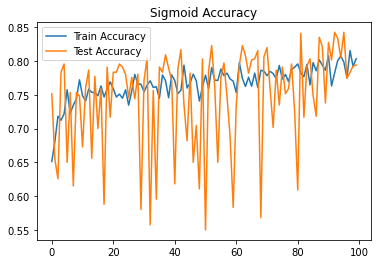

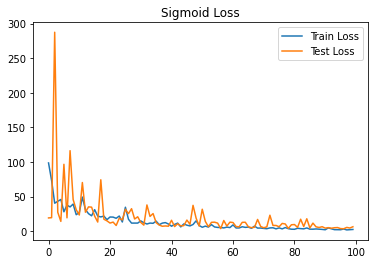

In [55]:
# 5x5, 32 channels, 3 layers
plt.title('Sigmoid Accuracy')
plt.plot(ta)
plt.plot(tea)
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.show()

plt.title('Sigmoid Loss')
plt.plot(tl)
plt.plot(tel)
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [51]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    a[i] = ta[i] - tea[i]
    l[i] = tel[i] - tl[i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]

In [52]:
#Avg Difference in Accuracy
print(sa/100)

0.019815148067707778


In [53]:
#Avg Difference in Loss
sl/100

tensor(6.0085)

In [54]:
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+ta[i]
    sl1 = sl1+tl[i]
    sa2 = sa2+tea[i]
    sl2 = sl2+tel[i]

In [56]:
sa1

76.73302995828595

In [57]:
sa2

74.75151515151515

In [60]:
sl1/100

tensor(13.5552)

In [61]:
sl2/100

tensor(19.5636)